- 전처리팁
    - 결측치확인, 분포확인, 통계량 확인
    - 분포에서 지나치게 극단값을 가지는 아웃라이어 확인
    - 데이터변형

- 다중회귀모델


아이디어
- 소셜 네트워크 광고인만큼 어떤 대상을 타겟으로 광고를 집중하는 것이 이득인지를 알아내는 것이 목적.
- 나이, 성별, 급여가 이들을 나눌 수 있는 그룹.- 독립변수로 생성
- 구매여부 - 종속변수
- 모델
    - 랜덤포레스트 분류
    - 다중회귀
    - 임금, 나이별 클러스터링
    - KNN
    - 생존분석

- 검증
    - 교차검증
    - shap


패키지

In [178]:
# 분석
import pandas as pd
import numpy as np
import scipy.stats as stats
import string
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


# 시각화
import seaborn as sns
import matplotlib.pyplot as plt


# 머신러닝 패키지
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
import shap
from sklearn.metrics import roc_curve, roc_auc_score
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis


shap.initjs()

데이터셋

In [113]:
df = pd.read_csv("./data/Social_Network_Ads.csv")
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   User ID          400 non-null    int64 
 1   Gender           400 non-null    object
 2   Age              400 non-null    int64 
 3   EstimatedSalary  400 non-null    int64 
 4   Purchased        400 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.8+ KB


데이터탐색

In [3]:
df.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [4]:
df.duplicated().sum()

0

In [121]:
df.describe().iloc[:, 1:]

,Age,EstimatedSalary,Purchased
count,400.000000,400.000000,400.000000
mean,37.655000,69742.500000,0.357500
std,10.482877,34096.960282,0.479864
min,18.000000,15000.000000,0.000000
25%,29.750000,43000.000000,0.000000
50%,37.000000,70000.000000,0.000000
75%,46.000000,88000.000000,1.000000
max,60.000000,150000.000000,1.000000


In [6]:
sorted(df["Age"].unique())

[18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60]

In [124]:
df[df["Age"] == 19]

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
4,15804002,Male,19,76000,0
104,15672091,Female,19,21000,0
139,15741094,Male,19,25000,0
140,15807909,Male,19,85000,0
191,15662067,Female,19,26000,0
193,15662901,Male,19,70000,0


나이가 너무 적거나 급여가 너무 극단값에 있는 것은 이상치로 고려해볼 수 있지만 우선 진행

EDA

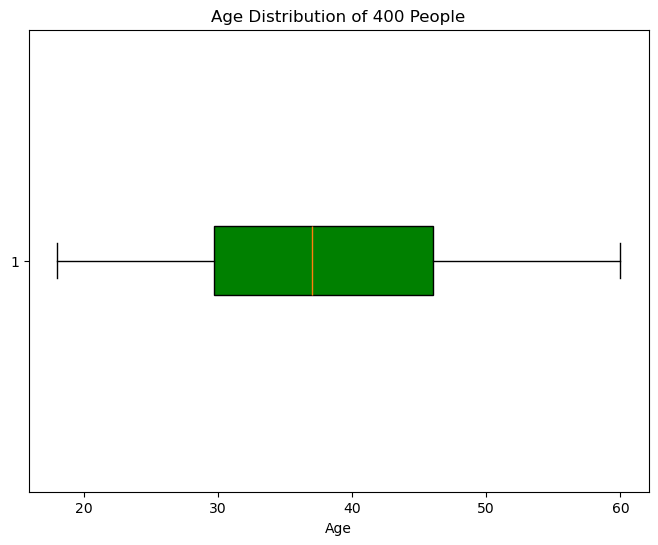

In [140]:
plt.figure(figsize=(8, 6))
plt.boxplot(df["Age"], vert=False, patch_artist=True, boxprops=dict(facecolor="green"))
plt.title("Age Distribution of 400 People")
plt.xlabel("Age")
plt.show()

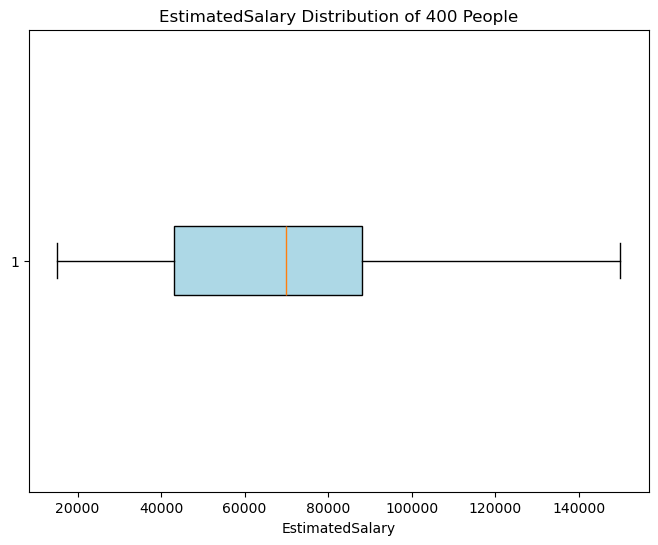

In [148]:
plt.figure(figsize=(8, 6))
plt.boxplot(
    df["EstimatedSalary"],
    vert=False,
    patch_artist=True,
    boxprops=dict(facecolor="lightblue"),
)
plt.title("EstimatedSalary Distribution of 400 People")
plt.xlabel("EstimatedSalary")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_21692\3269870736.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df["EstimatedSalary"])


Text(0.5, 0, 'EstimatedSalary')

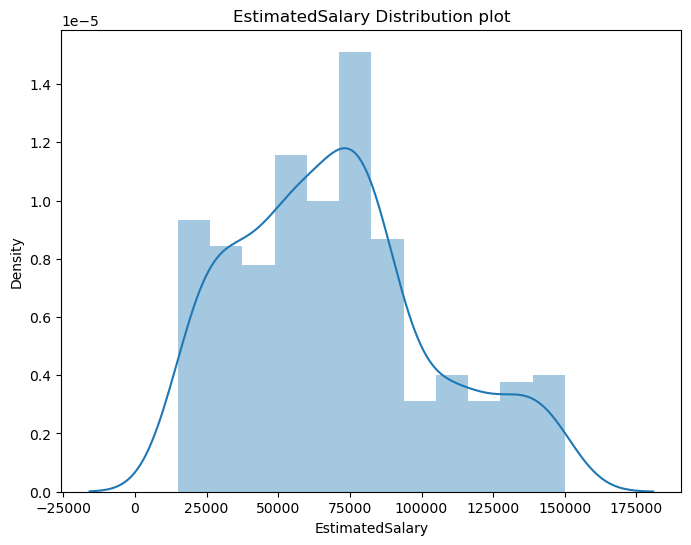

In [142]:
plt.figure(figsize=(8, 6))

sns.distplot(x=df["EstimatedSalary"])
plt.title("EstimatedSalary Distribution plot")
plt.xlabel("EstimatedSalary")

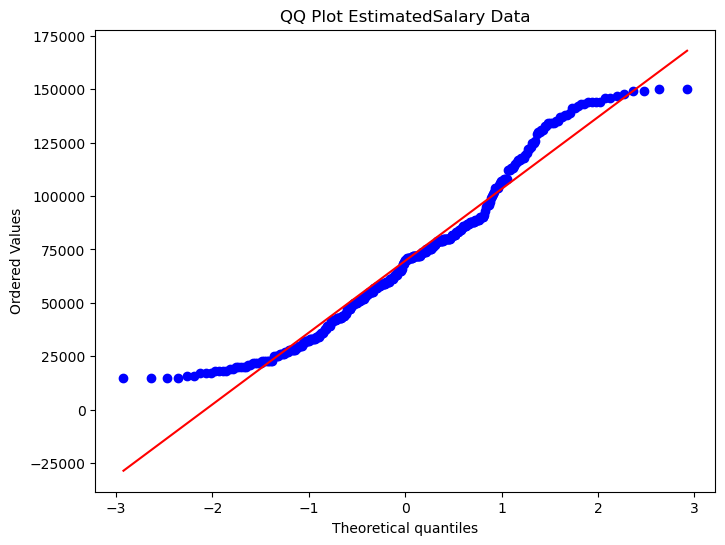

In [147]:
plt.figure(figsize=(8, 6))

stats.probplot(df["EstimatedSalary"], dist="norm", plot=plt)
plt.title("QQ Plot EstimatedSalary Data")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_21692\2373214532.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df["Age"])


Text(0.5, 0, 'Age')

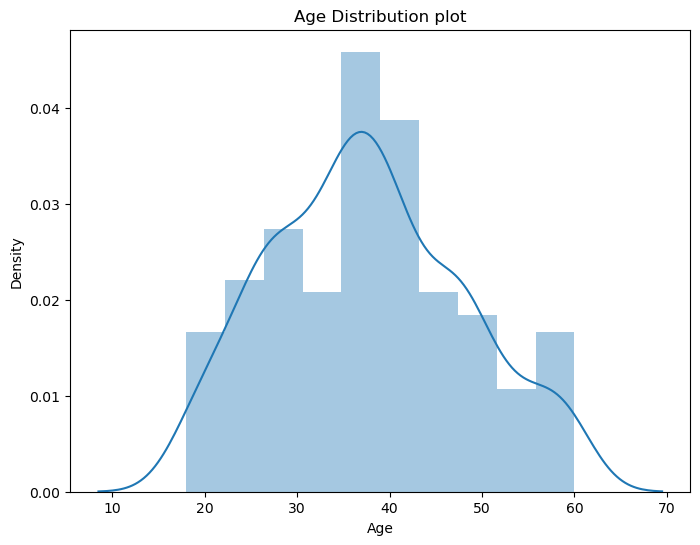

In [143]:
plt.figure(figsize=(8, 6))

sns.distplot(x=df["Age"])
plt.title("Age Distribution plot")
plt.xlabel("Age")

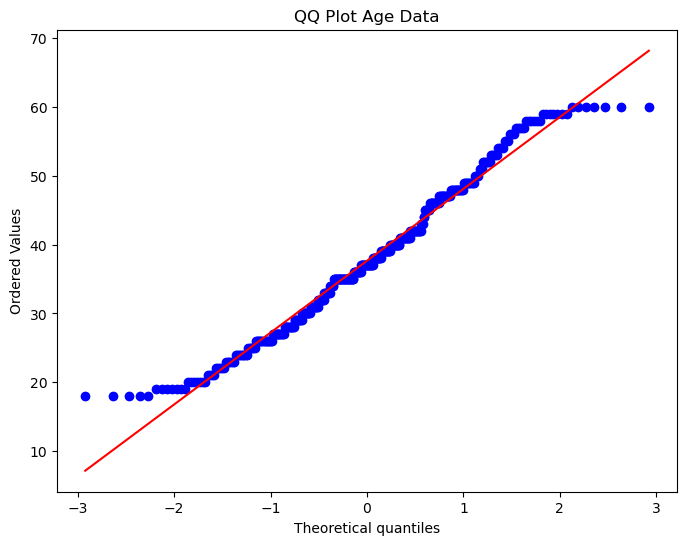

In [146]:
plt.figure(figsize=(8, 6))

stats.probplot(df["Age"], dist="norm", plot=plt)
plt.title("QQ Plot Age Data")
plt.show()

전처리

In [11]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0
...,...,...,...,...,...
395,15691863,Female,46,41000,1
396,15706071,Male,51,23000,1
397,15654296,Female,50,20000,1
398,15755018,Male,36,33000,0


성별은 string 타입임으로 레이블 인코더로 전처리

In [128]:
# encoding
encoder = LabelEncoder()
encoder.fit(df["Gender"])

# transform
df["Gender"] = encoder.transform(df["Gender"])

In [150]:
df["Gender"]

0      1
1      1
2      0
3      0
4      1
      ..
395    0
396    1
397    0
398    1
399    0
Name: Gender, Length: 400, dtype: int32

연령대를 구간으로 나눠 새로운 열 추가

In [129]:
df["Age_label"] = 0

In [130]:
df["Age_label"] = 0  # 초기화
df["Age_label"][df["Age"] >= 10] = 1
df["Age_label"][df["Age"] >= 20] = 2
df["Age_label"][df["Age"] >= 30] = 3
df["Age_label"][df["Age"] >= 40] = 4
df["Age_label"][df["Age"] >= 50] = 5

C:\Users\user\AppData\Local\Temp\ipykernel_21692\2680884106.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["Age_label"][df["Age"] >= 10] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_21692\2680884106.py:2: SettingWithCopyWarning: 
A

In [15]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,15624510,1,19,19000,0,1
1,15810944,1,35,20000,0,3
2,15668575,0,26,43000,0,2
3,15603246,0,27,57000,0,2
4,15804002,1,19,76000,0,1
...,...,...,...,...,...,...
395,15691863,0,46,41000,1,4
396,15706071,1,51,23000,1,5
397,15654296,0,50,20000,1,5
398,15755018,1,36,33000,0,3


In [16]:
age_salary_mean = df.groupby("Age_label")["EstimatedSalary"].mean()

# 결과 출력
print(age_salary_mean)

Age_label
1    54500.000000
2    60443.181818
3    73079.710145
4    70201.834862
5    79000.000000
Name: EstimatedSalary, dtype: float64


<Axes: xlabel='Age_label', ylabel='EstimatedSalary'>

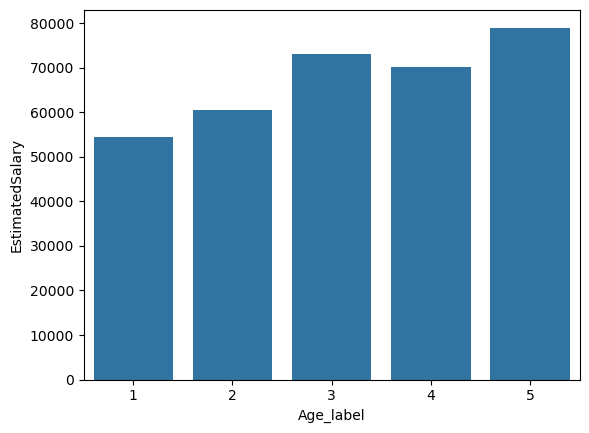

In [17]:
sns.barplot(age_salary_mean)

In [18]:
scaler = StandardScaler()
scaler.fit(df)
scaled = scaler.transform(df)

df_scaled = pd.DataFrame(data=scaled, columns=df.columns)
df_scaled

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,-0.936579,1.020204,-1.781797,-1.490046,-0.745936,-2.176118
1,1.668387,1.020204,-0.253587,-1.460681,-0.745936,-0.248217
2,-0.320877,-0.980196,-1.113206,-0.785290,-0.745936,-1.212168
3,-1.233692,-0.980196,-1.017692,-0.374182,-0.745936,-1.212168
4,1.571389,1.020204,-1.781797,0.183751,-0.745936,-2.176118
...,...,...,...,...,...,...
395,0.004517,-0.980196,0.797057,-0.844019,1.340598,0.715733
396,0.203039,1.020204,1.274623,-1.372587,1.340598,1.679684
397,-0.520392,-0.980196,1.179110,-1.460681,1.340598,1.679684
398,0.886955,1.020204,-0.158074,-1.078938,-0.745936,-0.248217


In [19]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,15624510,1,19,19000,0,1
1,15810944,1,35,20000,0,3
2,15668575,0,26,43000,0,2
3,15603246,0,27,57000,0,2
4,15804002,1,19,76000,0,1
...,...,...,...,...,...,...
395,15691863,0,46,41000,1,4
396,15706071,1,51,23000,1,5
397,15654296,0,50,20000,1,5
398,15755018,1,36,33000,0,3


C:\Users\user\AppData\Local\Temp\ipykernel_21692\1955396290.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_scaled["EstimatedSalary"])


<Axes: ylabel='Density'>

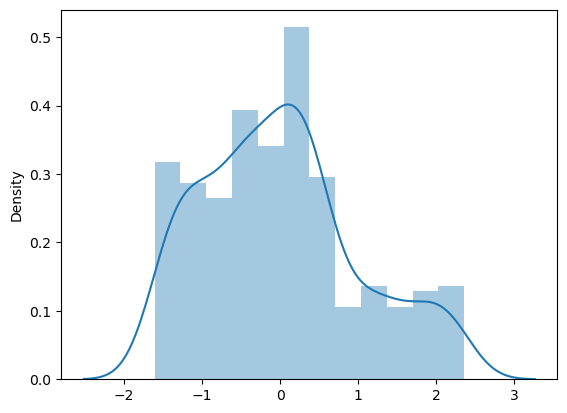

In [20]:
sns.distplot(x=df_scaled["EstimatedSalary"])

C:\Users\user\AppData\Local\Temp\ipykernel_21692\1334291350.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df_scaled["Age"])


<Axes: ylabel='Density'>

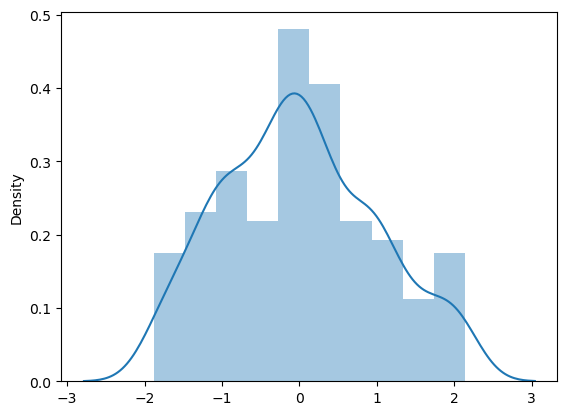

In [21]:
sns.distplot(x=df_scaled["Age"])

C:\Users\user\AppData\Local\Temp\ipykernel_21692\1314230494.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x=df["Age_label"])


<Axes: ylabel='Density'>

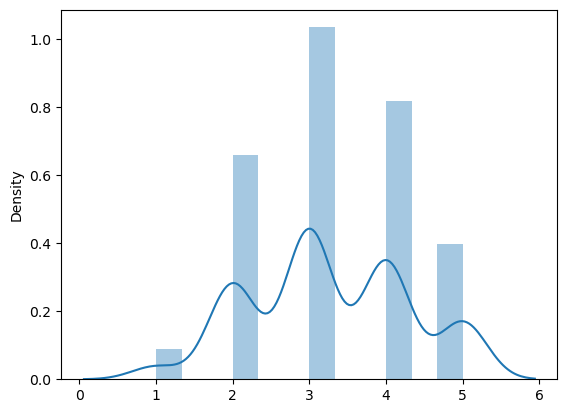

In [22]:
sns.distplot(x=df["Age_label"])

Text(0.5, 1.0, 'Regplot')

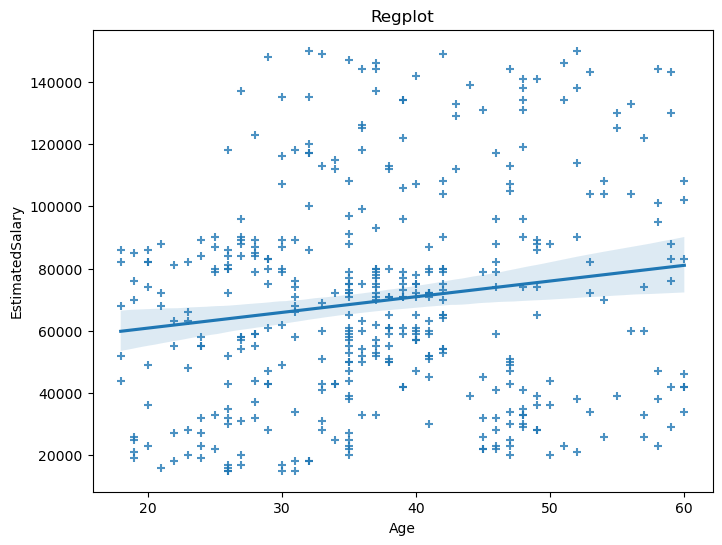

In [149]:
plt.figure(figsize=(8, 6))

sns.regplot(data=df, x="Age", y="EstimatedSalary", marker="+")

plt.title("Regplot")

나이와 수입 사이의 상관분석

In [111]:
rho_t, p_val_t = stats.pearsonr(df["Age"], df["EstimatedSalary"])

print("correaltion coefficient : {}, p-value : {}".format(rho_t, p_val_t))

correaltion coefficient : 0.15523801797210007, p-value : 0.0018460568005798244


모델

In [23]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          400 non-null    float64
 1   Gender           400 non-null    float64
 2   Age              400 non-null    float64
 3   EstimatedSalary  400 non-null    float64
 4   Purchased        400 non-null    float64
 5   Age_label        400 non-null    float64
dtypes: float64(6)
memory usage: 18.9 KB


In [153]:
X = df[["Gender", "Age", "EstimatedSalary", "Age_label"]]
y = df["Purchased"]

In [154]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.2, random_state=12345
)

분류모델

In [155]:
rfc = RandomForestClassifier(random_state=12345)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=12345)

In [156]:
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

1.0
0.86875


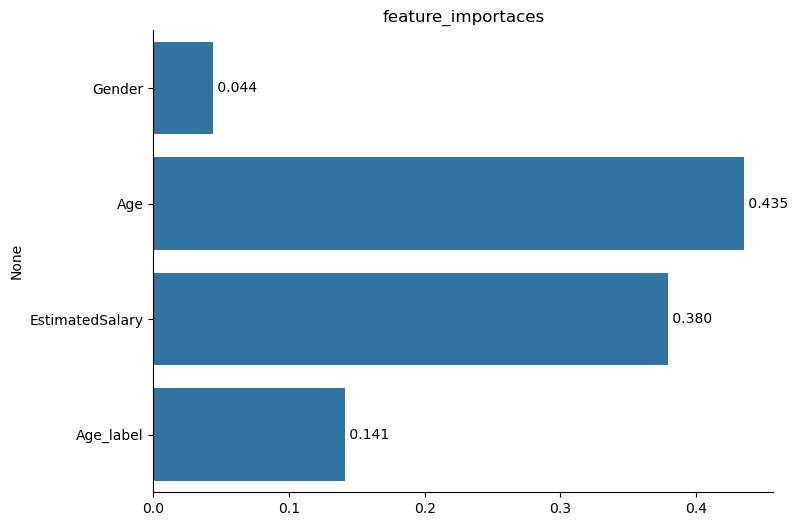

In [158]:
# feature_importance

plt.figure(figsize=(8, 6))
ax = sns.barplot(x=rfc.feature_importances_, y=X.columns)
ax.bar_label(ax.containers[0], fmt=" %.3f")
plt.gca().spines[["right", "top"]].set_visible(False)
plt.title("feature_importaces")
plt.show()

In [29]:
rfc.predict

<bound method ForestClassifier.predict of RandomForestClassifier(random_state=12345)>

In [30]:
# shap

explainer = shap.KernelExplainer(rfc.predict, X_train)
explainer

In [31]:
shap_train = explainer.shap_values(X_train)
shap_test = explainer.shap_values(X_test)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

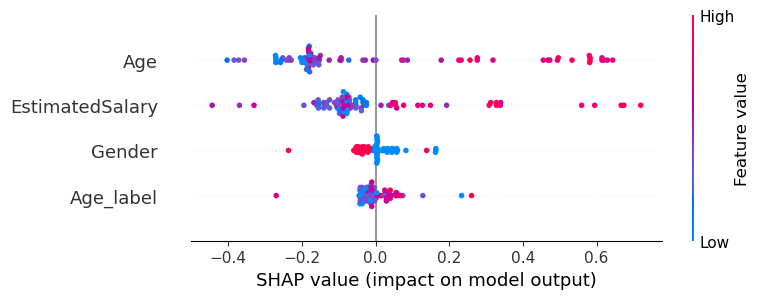

In [32]:
shap.summary_plot(shap_train, X_train)

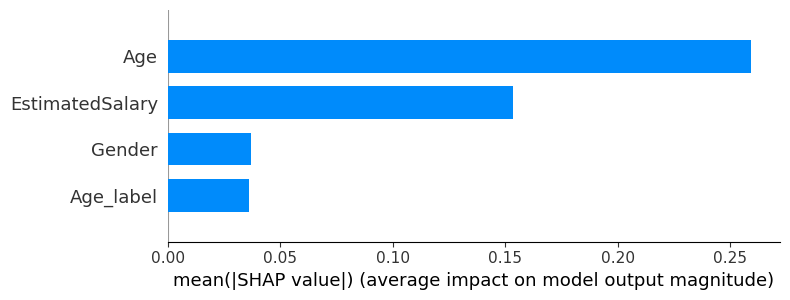

In [33]:
shap.summary_plot(shap_train, X_train, plot_type="bar")

In [34]:
shap_value = explainer.shap_values(X_test)

  0%|          | 0/320 [00:00<?, ?it/s]

In [35]:
shap.force_plot(explainer.expected_value, shap_value, X_test)

In [36]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label
0,15624510,1,19,19000,0,1
1,15810944,1,35,20000,0,3
2,15668575,0,26,43000,0,2
3,15603246,0,27,57000,0,2
4,15804002,1,19,76000,0,1
...,...,...,...,...,...,...
395,15691863,0,46,41000,1,4
396,15706071,1,51,23000,1,5
397,15654296,0,50,20000,1,5
398,15755018,1,36,33000,0,3


In [37]:
shap.force_plot(explainer.expected_value, shap_value[0], X_test.iloc[0], link="logit")

In [43]:
y

0      0
1      0
2      0
3      0
4      0
      ..
395    1
396    1
397    1
398    0
399    1
Name: Purchased, Length: 400, dtype: int64

In [46]:
train_index

array([ 68,  69,  70,  71,  72,  73,  74,  76,  77,  78,  79,  80,  81,
        82,  83,  84,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  98,  99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 161, 162, 163, 164, 165, 166,
       167, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194,
       195, 196, 197, 198, 199, 200, 201, 203, 205, 206, 207, 208, 209,
       210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
       223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
       236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
       249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 26

In [49]:
X.values

array([[    1,    19, 19000,     1],
       [    1,    35, 20000,     3],
       [    0,    26, 43000,     2],
       ...,
       [    0,    50, 20000,     5],
       [    1,    36, 33000,     3],
       [    0,    49, 36000,     4]], dtype=int64)

In [45]:
test_index

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  75,  85,  97, 103, 137, 146, 159, 160, 168, 182,
       202, 204])

In [52]:
skfold = StratifiedKFold(n_splits=30, shuffle=False)
cv_index = skfold.split(X, y)

cv_accuracy = []
ind = 1

for train_index, test_index in cv_index:
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rfc.fit(X_train, y_train)
    accuracy = rfc.score(X_test, y_test)

    print(f"{ind}번째 Cross Validation 정확도: {accuracy:.2%}")
    cv_accuracy.append(accuracy)

    ind += 1

print(
    f"""-------------------------------------------
Cross Validation 정확도 평균: {np.mean(cv_accuracy):.2%}"""
)

1번째 Cross Validation 정확도: 100.00%
2번째 Cross Validation 정확도: 92.86%
3번째 Cross Validation 정확도: 100.00%
4번째 Cross Validation 정확도: 78.57%
5번째 Cross Validation 정확도: 78.57%
6번째 Cross Validation 정확도: 85.71%
7번째 Cross Validation 정확도: 85.71%
8번째 Cross Validation 정확도: 92.86%
9번째 Cross Validation 정확도: 85.71%
10번째 Cross Validation 정확도: 100.00%
11번째 Cross Validation 정확도: 92.31%
12번째 Cross Validation 정확도: 100.00%
13번째 Cross Validation 정확도: 92.31%
14번째 Cross Validation 정확도: 100.00%
15번째 Cross Validation 정확도: 100.00%
16번째 Cross Validation 정확도: 92.31%
17번째 Cross Validation 정확도: 76.92%
18번째 Cross Validation 정확도: 84.62%
19번째 Cross Validation 정확도: 92.31%
20번째 Cross Validation 정확도: 84.62%
21번째 Cross Validation 정확도: 61.54%
22번째 Cross Validation 정확도: 84.62%
23번째 Cross Validation 정확도: 84.62%
24번째 Cross Validation 정확도: 84.62%
25번째 Cross Validation 정확도: 84.62%
26번째 Cross Validation 정확도: 76.92%
27번째 Cross Validation 정확도: 92.31%
28번째 Cross Validation 정확도: 100.00%
29번째 Cross Validation 정확도: 92.31%
30번째 Cross Valid

다중회귀

In [54]:
df.columns

Index(['User ID', 'Gender', 'Age', 'EstimatedSalary', 'Purchased',
       'Age_label'],
      dtype='object')

<Axes: xlabel='Age', ylabel='EstimatedSalary'>

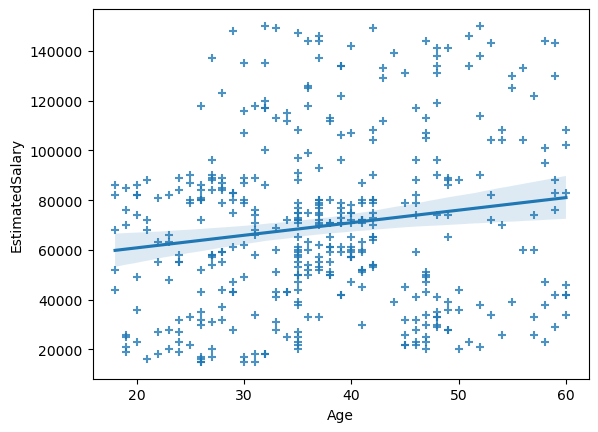

In [57]:
sns.regplot(data=df, x="Age", y="EstimatedSalary", marker="+")

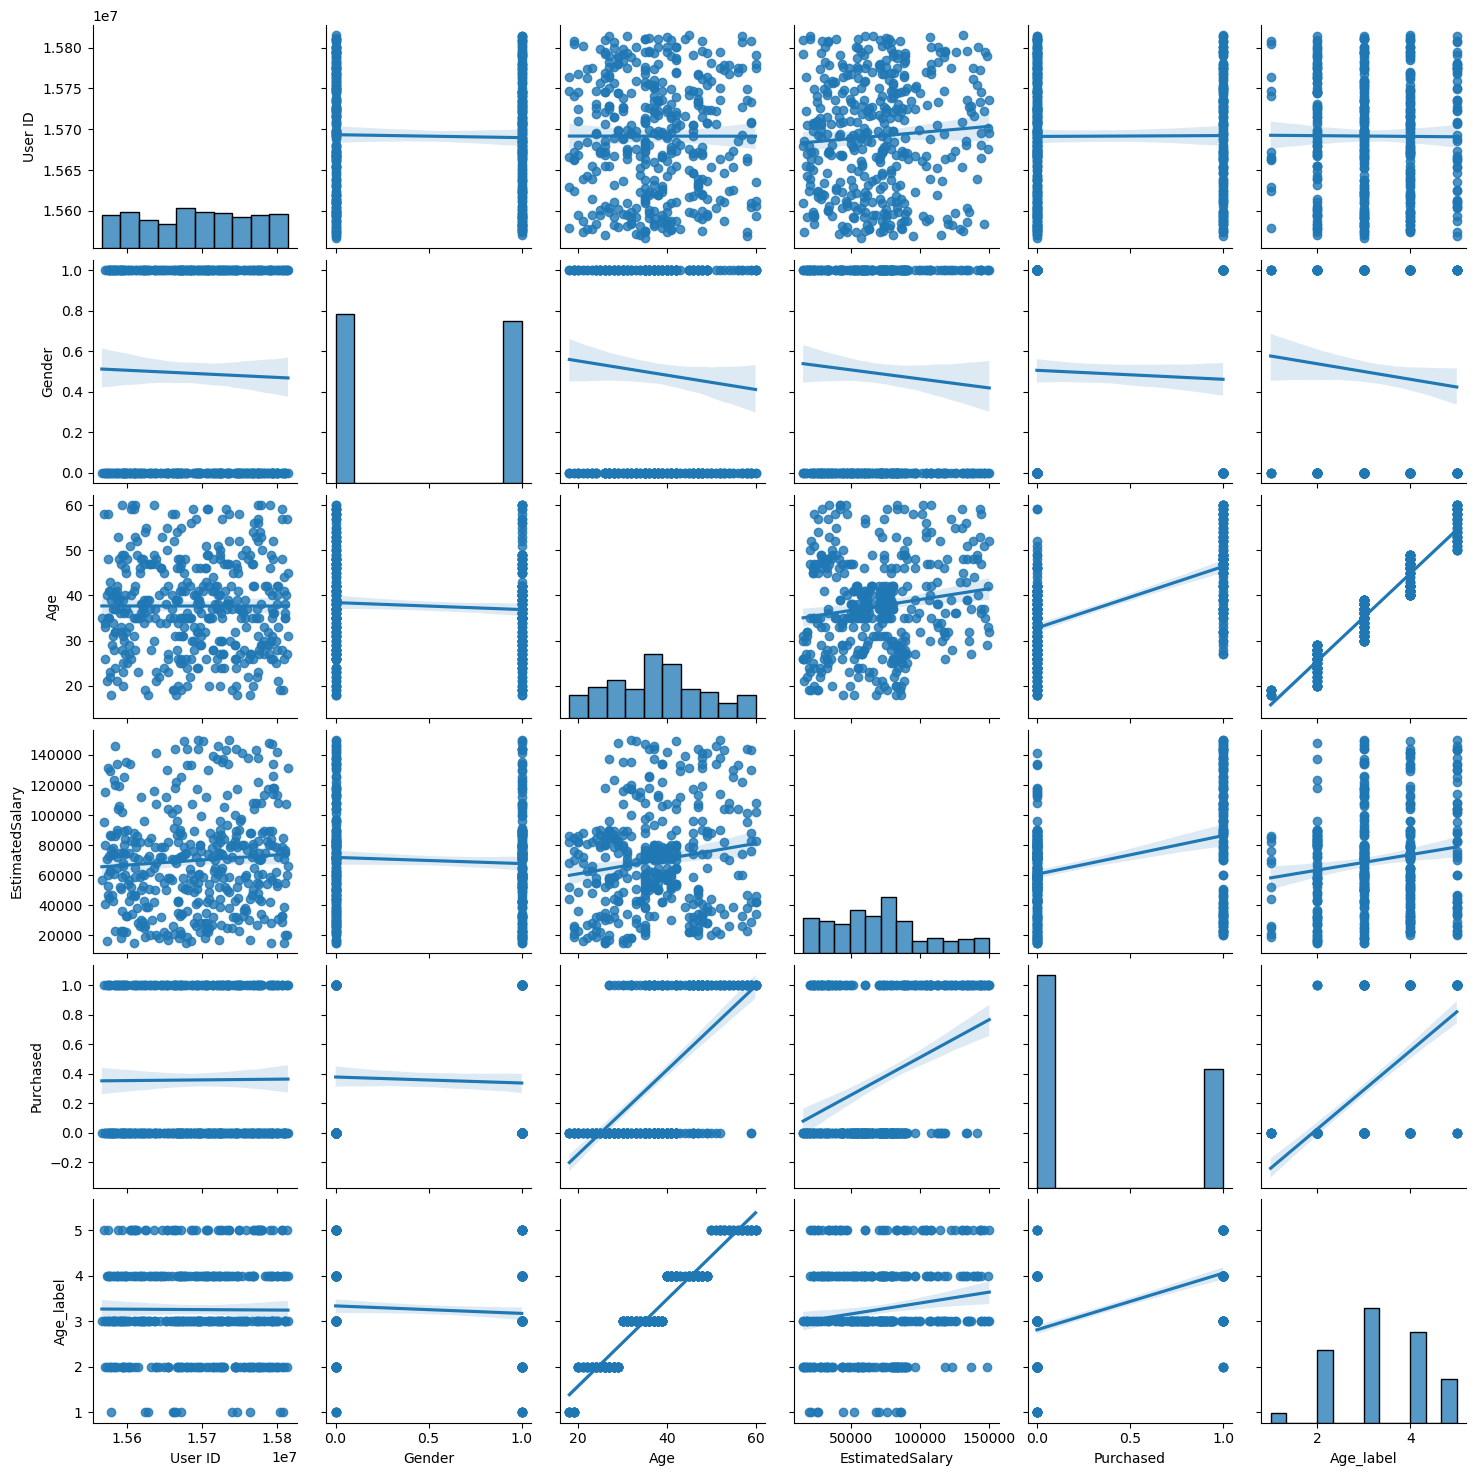

In [64]:
sns.pairplot(df, kind="reg")
plt.show()

In [184]:
from sklearn.linear_model import LogisticRegression


softmax_reg = LogisticRegression(random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [185]:
print(softmax_reg.score(X_train, y_train))
print(softmax_reg.score(X_test, y_test))

0.6625
0.6375


In [186]:
explainer = shap.KernelExplainer(softmax_reg.predict, X_train)
explainer

In [187]:
shap_train = explainer.shap_values(X_train)
shap_test = explainer.shap_values(X_test)

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

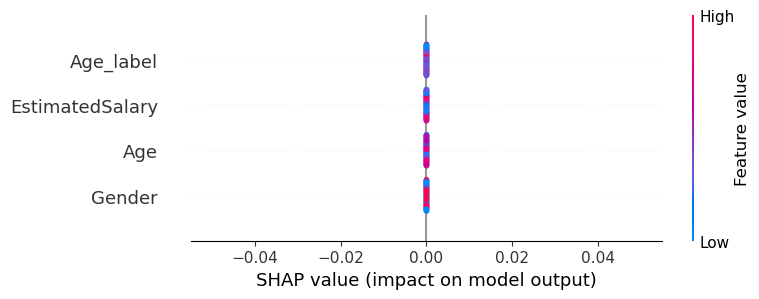

In [188]:
shap.summary_plot(shap_train, X_train)

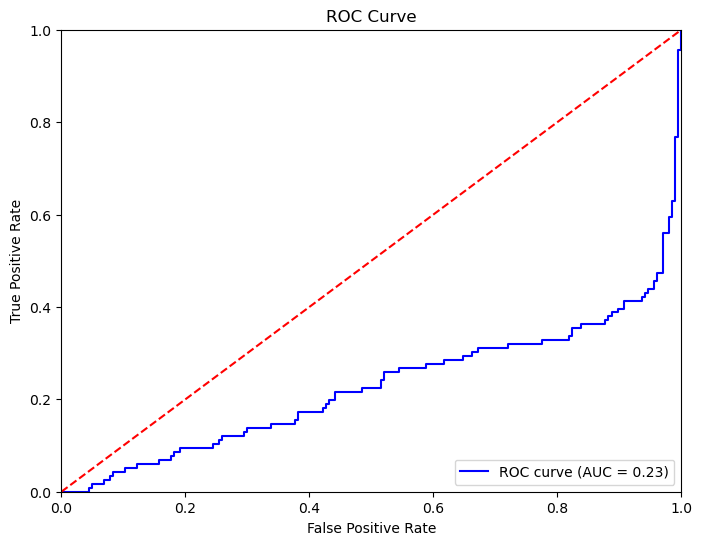

In [189]:
y_probs = softmax_reg.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률만 가져옵니다.

# ROC 곡선을 그리기 위해 fpr, tpr 값을 계산합니다.
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# ROC AUC 점수를 계산합니다.
roc_auc = roc_auc_score(y_test, y_probs)

# ROC 곡선을 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

클러스터링

In [62]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)

y_pred = kmeans.fit_predict(X)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [ ]:
df["Age_label"]

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


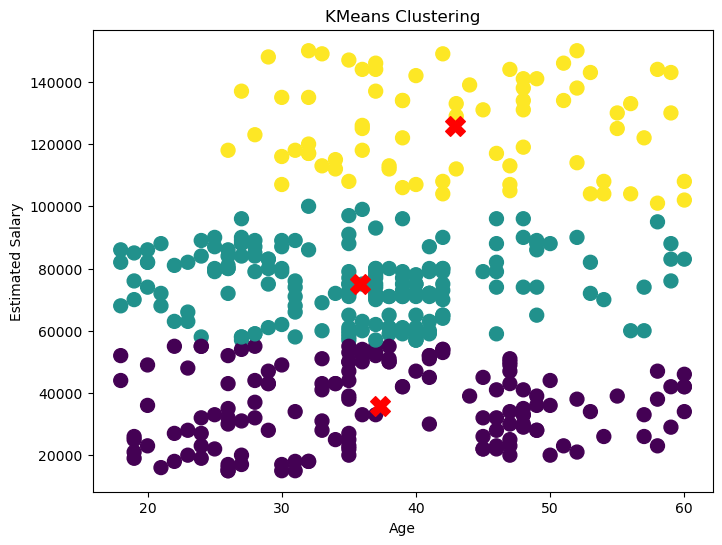

In [106]:
X = df[["Age", "EstimatedSalary", "Purchased"]]

# KMeans 모델을 생성하고 클러스터링을 수행합니다.
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df["Age"], df["EstimatedSalary"], c=df["Cluster"], cmap="viridis", s=100)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200,
    c="red",
    marker="X",
)
plt.title("KMeans Clustering")
plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.show()

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


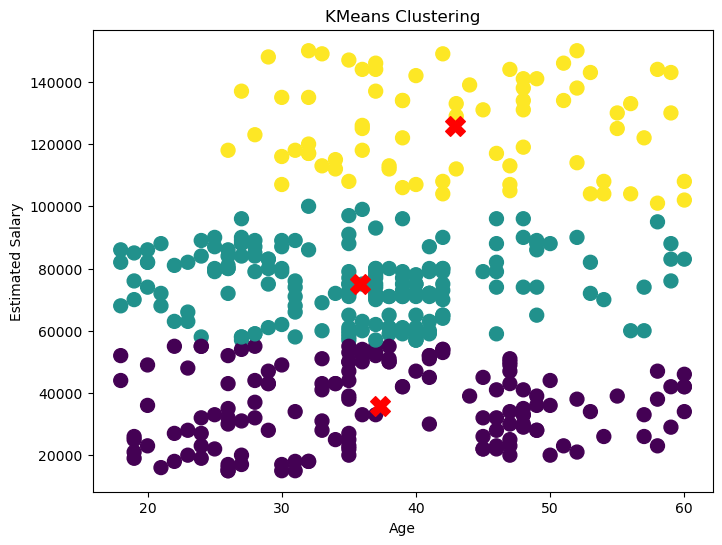

In [190]:
X = df[["Age", "EstimatedSalary", "Purchased"]]

scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

# KMeans 모델을 생성하고 클러스터링을 수행합니다.
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(X)

# 클러스터링 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df["Age"], df["EstimatedSalary"], c=df["Cluster"], cmap="viridis", s=100)
plt.scatter(
    kmeans.cluster_centers_[:, 0],
    kmeans.cluster_centers_[:, 1],
    s=200,
    c="red",
    marker="X",
)
plt.title("KMeans Clustering")
plt.xlabel("Age")
plt.ylabel("Estimated Salary")
plt.show()

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

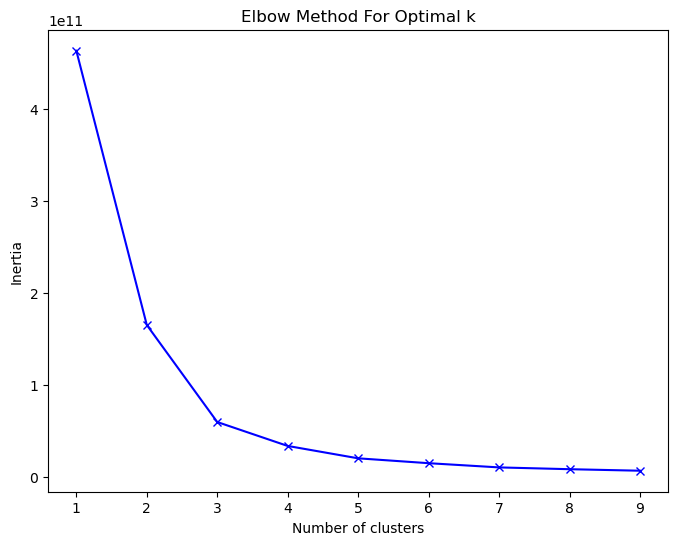

In [104]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# 클러스터링을 위한 피처 선택 (Age와 EstimatedSalary)
X = df[["Age", "EstimatedSalary", "Purchased"]]

# 엘보우 방법을 사용하여 적절한 클러스터 수를 찾습니다.
inertia = []
K = range(1, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프를 그립니다.
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

In [107]:
df_nonid = df.drop(columns=["User ID"])

# 데이터를 표준화
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_nonid)

# KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=3, random_state=42)
df_nonid["Cluster"] = kmeans.fit_predict(df_scaled)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


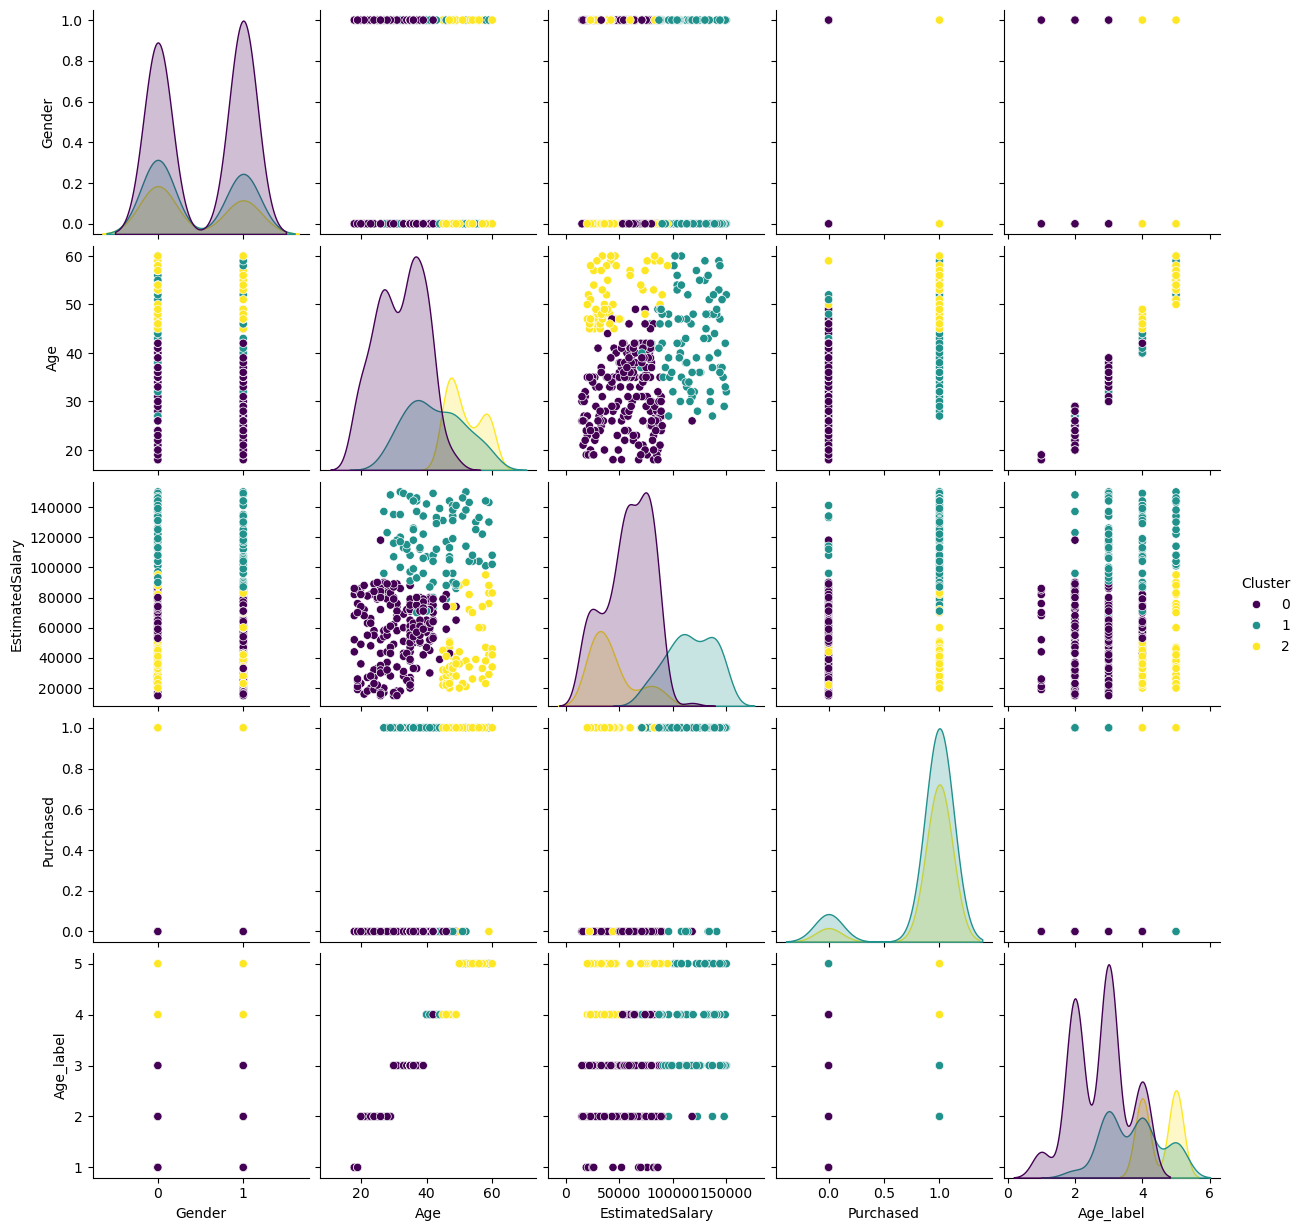

클러스터 센트로이드:
 [[ 0.0739567  -0.53497459 -0.33933376 -0.74593581 -0.50020435 -0.30467027]
 [-0.08418351  0.46972561  1.36018016  1.10151593  0.45466336  1.30341187]
 [-0.1546341   1.33071772 -0.77456917  1.17500001  1.22065979 -0.82066674]]


In [109]:
sns.pairplot(df_nonid, hue="Cluster", palette="viridis", diag_kind="kde")
plt.show()

# 클러스터의 중심 확인
print("클러스터 센트로이드:\n", kmeans.cluster_centers_)

c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\user\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are les

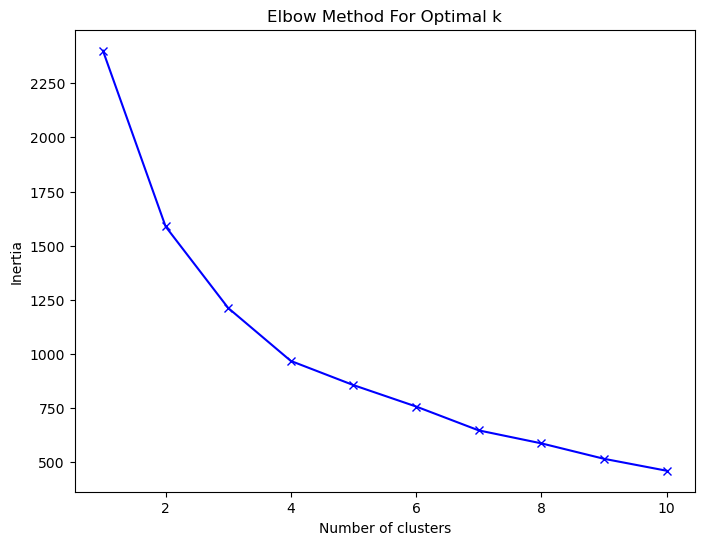

In [110]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)

# 엘보우 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

생존분석

In [183]:
df

,User ID,Gender,Age,EstimatedSalary,Purchased,Age_label,Purchased_bool
0,15624510,1,19,19000,0,1,False
1,15810944,1,35,20000,0,3,False
2,15668575,0,26,43000,0,2,False
3,15603246,0,27,57000,0,2,False
4,15804002,1,19,76000,0,1,False
...,...,...,...,...,...,...,...
395,15691863,0,46,41000,1,4,True
396,15706071,1,51,23000,1,5,True
397,15654296,0,50,20000,1,5,True
398,15755018,1,36,33000,0,3,False


In [163]:
df["Purchased"].value_counts()

Purchased
0    257
1    143
Name: count, dtype: int64

In [170]:
df["Purchased_bool"] = df["Purchased"].astype(bool)

<>:3: SyntaxWarning: invalid escape sequence '\h'
<>:3: SyntaxWarning: invalid escape sequence '\h'
C:\Users\user\AppData\Local\Temp\ipykernel_21692\799228398.py:3: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("est. probability of survival $\hat{S}(t)$")


Text(0.5, 0, 'time $t$')

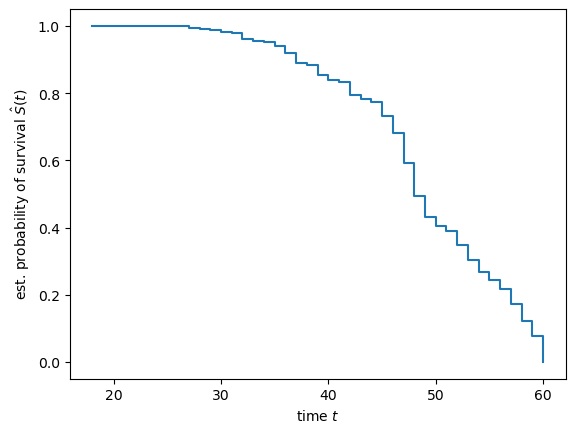

In [174]:
time, survival_prob = kaplan_meier_estimator(df["Purchased_bool"], df["Age"])
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

<>:5: SyntaxWarning: invalid escape sequence '\h'
<>:5: SyntaxWarning: invalid escape sequence '\h'
C:\Users\user\AppData\Local\Temp\ipykernel_21692\1367623149.py:5: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel("est. probability of survival $\hat{S}(t)$")


Text(0.5, 0, 'Salary')

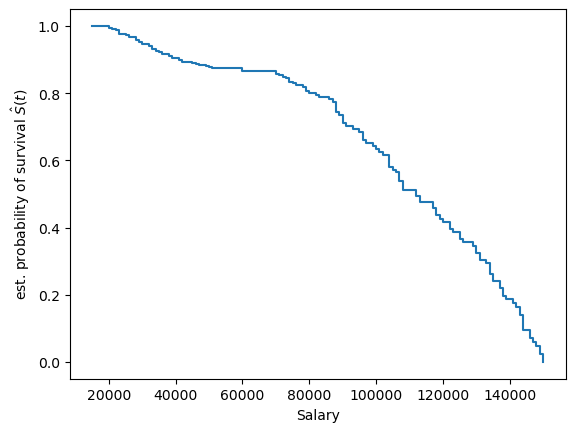

In [180]:
time, survival_prob = kaplan_meier_estimator(
    df["Purchased_bool"], df["EstimatedSalary"]
)
plt.step(time, survival_prob, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("Salary")

In [182]:
estimator = CoxPHSurvivalAnalysis()
estimator.fit(df[["Age"]], df[["Purchased_bool", "EstimatedSalary"]])

ValueError: y must be a structured array with the first field being a binary class event indicator and the second field the time of the event/censoring

In [179]:
def fit_and_score_features(X, y):

    n_features = X.shape[1]
    scores = np.empty(n_features)

    m = CoxPHSurvivalAnalysis()

    for j in range(n_features):

        Xj = X[:, j : j + 1]

        m.fit(Xj, y)

        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(df.values, df)

pd.Series(scores, index=df.columns).sort_values(ascending=False)

ValueError: y must be a structured array with the first field being a binary class event indicator and the second field the time of the event/censoring

모델들 k-fold로 판단
